In [1]:
from shapely.geometry import Point
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import xlrd
import time
from IPython.display import Audio
import dask.dataframe as dd
import fastparquet

In [2]:
#finish indicator
wow = '../../Data/Wow.mp3'
finished=Audio(url = wow, autoplay = True) 

#finish indicator
wow = '../../Data/Hugo Good Job.mp3'
complete=Audio(url = wow, autoplay = True) 

In [3]:
df = gpd.read_file('../../Data/Taxi Zones Shape/taxi_zones.shp').to_crs({'init': 'epsg:4326'})
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'},
    geometry=[Point(-73.966, 40.78)]), 
    df, how='left', op='within')

complete

C:\Users\Bro Bro\.conda\envs\geospatial\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

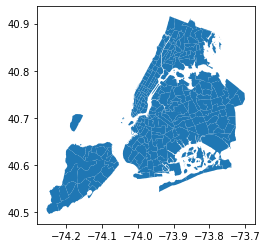

In [4]:
df.plot()

In [12]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):

    localdf = df[[lon_var, lat_var]].copy()
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = gpd.read_file('../../Data/Taxi Zones Shape/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs('EPSG:4326')

    try:
        local_gdf = gpd.GeoDataFrame(
            localdf, crs=('EPSG:4326'),
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = gpd.sjoin(
            local_gdf, shape_df, how='left', op='within')

        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
        return series

In [13]:
trips= dd.read_csv('../../Data/Taxi Data/yellow_14/yellow_tripdata_2014-01.csv',dtype={' tolls_amount': 'float64'})

In [14]:
trips['pickup_taxizone_id'] = trips.map_partitions(
    assign_taxi_zones, " pickup_longitude", " pickup_latitude",
    "pickup_taxizone_id", meta=('pickup_taxizone_id', np.float64))
trips['dropoff_taxizone_id'] = trips.map_partitions(
    assign_taxi_zones, " dropoff_longitude", " dropoff_latitude",
    "dropoff_taxizone_id", meta=('dropoff_taxizone_id', np.float64))
trips[['pickup_taxizone_id', 'dropoff_taxizone_id']].head()

#assume_missing=True

,pickup_taxizone_id,dropoff_taxizone_id
0,234.0,107.0
1,142.0,141.0
2,234.0,48.0
3,237.0,142.0
4,148.0,148.0


In [16]:
start_time = time.time()

df.to_parquet('df_2014-01.parquet', has_nulls=True,
     object_encoding='json', compression="SNAPPY")
df = dd.read_parquet('df_2014-015.parquet',
    columns=['pickup_taxizone_id', 'dropoff_taxizone_id'])

print("--- %s seconds ---" % (time.time() - start_time))

complete

--- 6593.59992814064 seconds ---


In [19]:
trips.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 2 entries, pickup_taxizone_id to dropoff_taxizone_id
dtypes: float64(2)

In [26]:
trips.describe()

,pickup_taxizone_id,dropoff_taxizone_id
npartitions=1,,
,float64,float64
,...,...


In [27]:
trips2= dd.read_csv('../../Data/Taxi Data/yellow_14/yellow_tripdata_2014-01.csv',dtype={' tolls_amount': 'float64'})

In [30]:
trips2.tail()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
125683,VTS,2014-01-06 13:12:00,2014-01-06 13:34:00,3,6.59,-73.993977,40.751317,1,NaN,-73.960392,40.811585,CRD,23.0,0.0,0.5,4.0,0.0,27.5
125684,VTS,2014-01-06 13:22:00,2014-01-06 13:36:00,1,0.75,-73.986945,40.736702,1,NaN,-73.998535,40.739857,CRD,10.0,0.0,0.5,2.0,0.0,12.5
125685,VTS,2014-01-06 13:32:00,2014-01-06 13:35:00,1,0.49,-73.974737,40.742057,1,NaN,-73.977228,40.746112,CRD,4.0,0.0,0.5,0.8,0.0,5.3
125686,VTS,2014-01-06 13:31:00,2014-01-06 13:34:00,1,0.71,-73.975580,40.759062,1,NaN,-73.983370,40.756030,CRD,4.5,0.0,0.5,0.9,0.0,5.9
125687,VTS,2014-01-06 13:25:00,2014-01-06 13:34:00,6,1.36,-73.944337,40.791930,1,NaN,-73.954465,40.779110,CSH,7.5,0.0,0.5,0.0,0.0,8.0


In [31]:
trips.tail()

,pickup_taxizone_id,dropoff_taxizone_id
125683,186.0,166.0
125684,107.0,90.0
125685,137.0,170.0
125686,161.0,230.0
125687,75.0,236.0


In [34]:
trips3=trips2.merge(trips2,trips, how=index)

NameError: name 'index' is not defined

In [35]:
trips4= pd.read_csv('../../Data/Taxi Data/yellow_14/yellow_tripdata_2014-01.csv',dtype={' tolls_amount': 'float64'})

In [37]:
trips3=trips2.merge(trips, how='inner', on=None)

In [41]:
trips3.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_taxizone_id,dropoff_taxizone_id
39,VTS,2014-01-04 13:02:00,2014-01-04 13:18:00,5,1.26,-73.97754,40.749417,1,NaN,-73.98463,40.758932,CSH,11.0,0.0,0.5,0.0,0.0,11.5,211.0,68.0
39,VTS,2014-01-04 13:02:00,2014-01-04 13:18:00,5,1.26,-73.97754,40.749417,1,NaN,-73.98463,40.758932,CSH,11.0,0.0,0.5,0.0,0.0,11.5,NaN,NaN
39,VTS,2014-01-04 13:02:00,2014-01-04 13:18:00,5,1.26,-73.97754,40.749417,1,NaN,-73.98463,40.758932,CSH,11.0,0.0,0.5,0.0,0.0,11.5,237.0,33.0
39,VTS,2014-01-04 13:02:00,2014-01-04 13:18:00,5,1.26,-73.97754,40.749417,1,NaN,-73.98463,40.758932,CSH,11.0,0.0,0.5,0.0,0.0,11.5,163.0,140.0
39,VTS,2014-01-04 13:02:00,2014-01-04 13:18:00,5,1.26,-73.97754,40.749417,1,NaN,-73.98463,40.758932,CSH,11.0,0.0,0.5,0.0,0.0,11.5,170.0,79.0


In [39]:
trips4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13782492 entries, 0 to 13782491
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   vendor_id            object 
 1    pickup_datetime     object 
 2    dropoff_datetime    object 
 3    passenger_count     int64  
 4    trip_distance       float64
 5    pickup_longitude    float64
 6    pickup_latitude     float64
 7    rate_code           int64  
 8    store_and_fwd_flag  object 
 9    dropoff_longitude   float64
 10   dropoff_latitude    float64
 11   payment_type        object 
 12   fare_amount         float64
 13   surcharge           float64
 14   mta_tax             float64
 15   tip_amount          float64
 16   tolls_amount        float64
 17   total_amount        float64
dtypes: float64(11), int64(2), object(5)
memory usage: 1.8+ GB
